# Initialisation du système

**Réseau discussion:**  
Nous initialisons **une matrice** de $ N\_1dim*N\_1dim=N $ individus. De plus, nous modélisons un réseau discussion par **un dictionaire**, qui associe à chaque individu un tuple, de la forme $ dict[str:tuple[int,bool,float,float]] $. Celui-ci représentera intégralement un agent et ses caractéristiques.

On rappelle la description d'un agent : 

|Caractéristique||Nom    |Type   |Intervalle     |Valeur initiale  | Fixe ?    |
|:-------------:||:-----:|:-----:|:-------------:|:---------------:|:---------:|
|**Nom** : nom de l'agent (clé du dict)                                  ||**nom**    |str    |[str(0),str(N)]|str(k)|Oui|
|**Opinion** : y croit (1) ou non (0)                                    ||**op**     |int    |[0,1]          |0     |Non|
|**Déjà vu** : nb d'expositions à la news                                ||**deja_vu**|int   |[0,steps]   |0 |Non|
|**Force de persuasion** : capacité à convaincre qqun (accrue qd tend vers 1) ||**fp**|float  |[0,1]          |Random|Oui|
|**Conviction** : caractérise la conviction à la news (tend vers 1) ou non (tend vers 0)||**p**|float  |[0,1] |0.5   |Non| 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import random

#description d'un agent : nom:(opinion, deja_vu , force_de_persuasion , conviction)
#                         nom:(   op  , deja_vu ,       fp            ,     p     )

N_1dim = 5     #nb de membres du réseau sur une dimension
N = N_1dim**2  #nb de membres du réseau discussion physique
nb_om = 3      #nb d'organismes médiatiques
nb_malv = 6    #nb d'agents malveillants
steps = 100    #nb de pas de temps
seuil = 0.3    #seuil

#Initialisation d'un réseau d'humains :
Reseau_discu={str(k):(0,0,fp,0.5) for k in range(1,N+1) for fp in np.random.uniform(low=0.0, high=1.0,size=N)}
Noms_reseau_discu=[k for k in range(N)]

#Initialisation d'un réseau avec des agents malveillants :
def init_sys_avec_malv(n_1dim,nb_malv):
    
    Pop={str(k):(0,0,fp,0.5) for k in range(1,N+1) for fp in np.random.uniform(low=0.0, high=1.0,size=N)}
    L=np.random.choice(range(1,(n_1dim**2)+1), size=nb_malv, replace=False)
    for e in L:
        Pop[str(e)]=(1,0,0.9,0.8)
    
    return Pop

Pop_malv=init_sys_avec_malv(N_1dim,nb_malv)
print('Réseau avec malveillants : \n',Pop_malv)

#Initialisation d'un système avec organismes médiatiques:
List_om=np.random.choice(range(1,(N_1dim**2)+1), size=nb_om, replace=False)
print(List_om)

def init_ac_om(reseau,list_om):
    for name in reseau:
        if name[0] != 'O':
            if int(name) in set(list_om):
                reseau['OM'+str(name)]=(0,0,np.random.uniform(low=0.7,high=1.0),0.5)
                del reseau[name]
    return reseau

Pop_ac_om=init_ac_om(Reseau_discu,List_om)
print('Population avec médias : \n',Pop_ac_om)
        
#Représentation des agents en 2 dimensions (sur une matrice) :
Agents=np.arange(1,N_1dim*N_1dim+1).reshape(N_1dim,N_1dim)
print('Agents :\n',Agents)

#Réseau à valeurs quelconques (au milieu de la simulation par exemple) pour faire des tests :
Test_reseau={str(k):(np.random.choice([0,1]),np.random.choice(range(steps)),np.random.random_sample(),np.random.random_sample()) for k in range(1,N+1)}

#Matrice des opinions de départ :
def matrice_opinions(reseau,n_1dim):
    Op=np.zeros((n_1dim,n_1dim))
    i=0
    j=0
    for (nom,(op,deja_vu,persu,p)) in reseau.items():
        Op[i,j]=int(op)
        if j<(n_1dim-1):
            j=j+1
        elif j==(n_1dim-1):
            j=0
            i=i+1
    return Op

print(matrice_opinions(Pop_malv,N_1dim))

#Matrice des convictions de départ
def matrice_convic(reseau,n_1dim):
    C=np.zeros((n_1dim,n_1dim))
    i=0
    j=0
    for (nom,(opinion,deja_vu,persu,p)) in reseau.items():
        C[i,j]=p
        if j<(n_1dim-1):
            j=j+1
        elif j==(n_1dim-1):
            j=0
            i=i+1
    return C

print(matrice_convic(Pop_malv,N_1dim))

#CONSULTATION A DISTANCE
#Réseaux sociaux :


Réseau avec malveillants : 
 {'1': (1, 0, 0.9, 0.8), '2': (1, 0, 0.9, 0.8), '3': (1, 0, 0.9, 0.8), '4': (0, 0, 0.5999327224163465, 0.5), '5': (0, 0, 0.1834997089799697, 0.5), '6': (0, 0, 0.29860620673469906, 0.5), '7': (0, 0, 0.7668933498715718, 0.5), '8': (0, 0, 0.716091603217715, 0.5), '9': (0, 0, 0.4310008830405132, 0.5), '10': (0, 0, 0.8084415761027808, 0.5), '11': (0, 0, 0.6216925465969286, 0.5), '12': (0, 0, 0.9872207608693675, 0.5), '13': (1, 0, 0.9, 0.8), '14': (1, 0, 0.9, 0.8), '15': (0, 0, 0.532712678954898, 0.5), '16': (0, 0, 0.9453082898476298, 0.5), '17': (0, 0, 0.40991094032769804, 0.5), '18': (0, 0, 0.1759938880411237, 0.5), '19': (0, 0, 0.4642484693264003, 0.5), '20': (1, 0, 0.9, 0.8), '21': (0, 0, 0.06895647580017072, 0.5), '22': (0, 0, 0.4675894226732027, 0.5), '23': (0, 0, 0.058762249741268535, 0.5), '24': (0, 0, 0.1513130434673483, 0.5), '25': (0, 0, 0.9490096837572947, 0.5)}
[16 24 18]
Population avec médias : 
 {'1': (0, 0, 0.9342791802752388, 0.5), '2': (0, 0, 0.

**Réseaux sociaux :**  
Nous modéliserons les **10 réseaux sociaux les plus utilisés en 2017** par un dictionnaire du type $ dict[str:list[str]] $ qui à un nom de réseau social associe la liste de personnes inscrites.
Nous modéliserons un réseau virtuel par **un dictionnaire** qui à chaque agent (humain ou organisme médiatique) associe une liste d'amis ou d'abonnés. Il représentera la possibilité d'interaction.

# DISCUSSION PHYSIQUE

Dans cette première partie, nous nous concentrerons sur la propagation d'une fake news par le seul biais d'une interaction entre agents physiquement proches. Cette discussion pourra avoir lieu **entre 2 à 9 personnes**.

**Processus de discussion détaillé :** 
- **1ère étape : Mise à jour des convictions**  

A partir d'une matrice représentant l'ensemble de la population, nous sélectionnerons un agent et son voisinage pour créer une liste de 2 à 9 personnes : la **liste discussion**.
 - si il n'y a que _2 personnes_ dans la liste discussion, seule la **force de persuasion** influera et ce sur un seul agent, celui dont la force de persuasion est la plus faible. La mise à jour des convictions est alors régie par la loi suivante : lorsque $  fp_i $ < $  fp_j $ on applique la formule: $ p_i \leftarrow p_i + fp_i  \cdot ( p_j - p_i ) $
 - si la discussion comprend _de 3 à 9 personnes_, ce sera le **voisinage** qui influera sur la conviction de chacun selon la loi suivante. Chaque individu modifie sa conviction en fonction de la moyenne des convictions des autres pondérée de leur force de persuasion ($ moy = \frac{\sum p_i*fp_i}{\sum fp_i} $) et du seuil de persuasion $\sigma$ : si $ |p_i-moy| < \sigma $ alors $ p_i \leftarrow moy $ sinon, $p_i$ ne change pas.  


- **2ème étape : Mise à jour des opinions**  

Pour chaque agent, on modifie son opinion en fonction de sa conviction : si $ p_i  > 0.5 $ , $op_i$ passe de $0$ à $1$ et inversement.

# I-) Facteurs modifiant les paramètres

## 1- Influence du voisinage sur p

### a) Création d'une liste discussion

Tous les individus possèdent 8 voisins, où qu'ils soient. Soit A un agent :
- s'il se situe _au milieu de la matrice_ (pas sur les bords ni les coins) ses voisins seront ses voisins directs (en haut, en bas, en haut à gauche, etc...).
- s'il est _sur le bord supérieur_, ses 3 voisins du haut sont remplacés par les 3 agents situés en bas de la matrice correspondant aux mêmes lignes. On sélectionnera ses voisins de manière analogue s'il est sur une autre bordure.
- s'il est _sur le coin supérieur droit_, il possède 3 voisins directs (en bas, à gauche, en bas à gauche) auxquels on ajoutera les agents situés : sur le coin supérieur droit ainsi que son voisin du bas, sur le coin inférieur droit ainsi que son voisin de gauche, sur le coin inférieur gauche.

In [3]:
#Sélection d'un agent et de son voisinage pour établir un discussion
def selection_voisinage(Matrice,n_1dim):
    '''Sélection aléatoire des voisinages d'un individu
    '''
    L=[]                               #liste voisinage (pers susceptibles de discuter)
    Ldiscu=[]                          #liste discussion (pers qui vont discuter)
    size=np.random.choice(range(2,10)) #nb pers discussion
    
    ic=np.random.choice(range(n_1dim)) #ic,jc : indices de l'agent central
    jc=np.random.choice(range(n_1dim))
    a_central=Matrice[ic,jc]
    
    if ic>0 and ic<(n_1dim-1) and jc>0 and jc<(n_1dim-1):
        L=np.reshape(Matrice[ic-1 : ic+2 , jc-1 : jc+2] , 9)        
    elif ic==0 and jc>0 and jc<(n_1dim-1):          #a_central sur arête sup
        L=[(Matrice[ic,jc-1 : jc+2])
           ,(Matrice[ic+1,jc-1 : jc+2])
           ,(Matrice[n_1dim-1, jc-1 : jc+2])]
        L=np.reshape(L,9)
    elif ic==(n_1dim-1) and jc>0 and jc<(n_1dim-1): #a_central sur arête inf
        L=[(Matrice[ic,jc-1 : jc+2])
           ,(Matrice[ic-1,jc-1 : jc+2])
           ,(Matrice[0, jc-1 : jc+2])]
        L=np.reshape(L,9)        
    elif jc==0 and ic>0 and ic<(n_1dim-1):          #a_central sur arête gauche
        L=[(Matrice[ic-1 : ic+2,jc])
           ,(Matrice[ic-1 : ic+2,jc+1])
           ,(Matrice[ic-1 : ic+2,n_1dim-1])]
        L=np.reshape(L,9)        
    elif jc==(n_1dim-1) and ic>0 and ic<(n_1dim-1): #a_central sur arête droite
        L=[(Matrice[ic-1 : ic+2,jc])
           ,(Matrice[ic-1 : ic+2,jc-1])
           ,(Matrice[ic-1 : ic+2,0])]
        L=np.reshape(L,9)        
    elif a_central==1:                              #a_central sur coin sup/gauche
        L=[n_1dim,a_central,2,n_1dim*2,n_1dim+1,n_1dim+2,n_1dim*n_1dim,n_1dim*(n_1dim-1)+1,n_1dim*(n_1dim-1)+2]
        L=np.array(L)        
    elif a_central==n_1dim:                         #a_central sur coin sup/droit
        L=[n_1dim-1,a_central,1,n_1dim*2-1,n_1dim*2,n_1dim+1,n_1dim*n_1dim-1,n_1dim*n_1dim,n_1dim*(n_1dim-1)+1]
        L=np.array(L)
    elif a_central==n_1dim*(n_1dim-1)+1:            #a_central sur coin inf/gauche
        L=[n_1dim*(n_1dim-1),Matrice[ic-1,jc],Matrice[ic-1,jc+1]
          ,n_1dim*n_1dim,a_central,Matrice[ic,jc+1]
          ,1,2,n_1dim]
        L=np.array(L)        
    elif a_central==(n_1dim*n_1dim):                #a_central sur coin inf/droit
        L=[a_central-n_1dim-1,a_central-n_1dim,Matrice[ic-1,0]
          ,a_central-1,a_central,a_central-n_1dim+1
          ,1,n_1dim-1,n_1dim]
        L=np.array(L)
    
    Ldiscu=np.random.choice(L,size,replace=False)
             
    return Ldiscu

Population=np.arange(1,N_1dim*N_1dim+1).reshape(N_1dim,N_1dim)
List_discu=selection_voisinage(Population,N_1dim)
print('Population :\n',Population)
print('Liste des personnes qui vont discuter :',List_discu)

Population :
 [[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]
 [21 22 23 24 25]]
Liste des personnes qui vont discuter : [ 1 21 22  7 10]


### b) Modification des convictions (paramètre p) des agents de la liste discussion

In [4]:
#Modification du paramètre p de x en fonction de la force de persuasion de y et vice versa :
def force_persu(x, y, reseau):
        
    opx,deja_vux,fpx,px=reseau[str(x)]
    opy,deja_vuy,fpy,py=reseau[str(y)]
    if fpx>fpy:
        py=py+fpy*(px-py)
    elif fpy>fpx:
        px=px+fpx*(py-px)
    
    reseau[str(x)]=(opx,deja_vux+1,fpx,px)
    reseau[str(y)]=(opy,deja_vuy+1,fpy,py)
    
    return reseau


#Influence du voisinage :
    # si 2 personnes, force persu. Sinon, moyenne des p pondérée des fp; si abs(pi-moy)>seuil, pi=pi, sinon pi=moy
def influ_voisinage(list_discu,reseau,seuil):
    
    P=[]   #liste des convictions des membres de la discussion
    F=[]   #liste des forces de persuasion des membres de la discussion
    N=[]   #liste des noms des membres de la discussion
    i=0
    
    for k in list_discu:
        op_k,deja_k,fp_k,p_k=reseau[str(k)]
        N.append(int(k))
        P.append(p_k)
        F.append(fp_k)
            
    if len(N)==2:
        reseau=force_persu(N[0],N[1],reseau)
    else:
        for a in N:
            op_a,deja_a,fp_a,p_a=reseau[str(a)]
            other_p=P[0:a]+P[a+1:len(P)]
            other_fp=F[0:a]+F[a+1:len(F)]            
            moy=np.average(other_p,weights=other_fp)
            if abs(p_a-moy)<seuil:
                p_a=moy
            reseau[str(a)]=(op_a,deja_a+1,fp_a,p_a)
    
            
    return reseau

print(influ_voisinage(List_discu,Test_reseau,seuil))

{'1': (0, 38, 0.37248721886015934, 0.6143303349806982), '2': (0, 52, 0.5472950814105416, 0.3197111219399935), '3': (0, 43, 0.813685964284607, 0.19847598849170067), '4': (1, 62, 0.25901123583624974, 0.8165148325869003), '5': (1, 9, 0.4749760528994038, 0.8226416758365896), '6': (1, 54, 0.7625187057435644, 0.34181011959478935), '7': (1, 13, 0.9449109171164377, 0.6381161778559348), '8': (0, 67, 0.08930359049392689, 0.45915053962298724), '9': (0, 21, 0.21746189822188788, 0.3418938605674513), '10': (1, 18, 0.2310238629853767, 0.6381161778559348), '11': (0, 60, 0.7855095598493432, 0.8741639541477979), '12': (1, 53, 0.15885155312199173, 0.933964060658307), '13': (1, 85, 0.5124863752929828, 0.5792261852936139), '14': (1, 25, 0.47918630198644585, 0.5574088443904924), '15': (1, 56, 0.9567148544452603, 0.2262001305757232), '16': (1, 67, 0.8764413107378752, 0.033300619814157106), '17': (1, 98, 0.7359029146829211, 0.1174034657473847), '18': (1, 9, 0.6512517293025205, 0.4068306874428791), '19': (0, 4

# II-) Simulation

Un pas de temps (step) correspond ici à une discussion.

In [5]:
def simulation_op(reseau,n_1dim,mat_pop,names,steps,seuil):
    """retourne la matrice des OPINIONS de la population après un certain nb d'étapes"""
    
    M=matrice_opinions(reseau,n_1dim)
    results=[]
    results.append(M.copy())
    
    for simu in range(steps):
        i=np.random.choice(names)
        List_discu=selection_voisinage(mat_pop,n_1dim)
        Res_p_changé=influ_voisinage(List_discu,reseau,seuil)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        Op=[]
        P=[]
        for e in Res_p_changé:
            op,deja,fp,p=Res_p_changé[e]
            Op.append(op)
            P.append(p)
        Op_final=np.reshape(Op, (n_1dim,n_1dim))
        P_final=np.reshape(P, (n_1dim,n_1dim))
        results.append(Op_final.copy())
        
    return results

simulation_op(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

[array([[0., 0., 1., 0., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.]]), array([[0, 0, 1, 0, 1],
        [1, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]), array([[0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]), array([[0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0],
        [1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0],
        [1, 0, 1, 1, 1],
        [1, 1, 0, 1, 0],
        [0, 1, 1, 1, 0]]), array([[0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1]]), array([[0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]]), array([[0, 0, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 0, 1, 1, 1],
        [1, 1, 1, 

In [6]:
def simulation_p(reseau,n_1dim,mat_pop,names,steps,seuil):
    """retourne la matrice des CONVICTIONS de la population après un certain nb d'étapes"""
    
    M=matrice_convic(reseau,n_1dim)
    results=[]
    results.append(M.copy())
    
    for simu in range(steps):
        i=np.random.choice(names)
        List_discu=selection_voisinage(mat_pop,n_1dim)
        Res_p_changé=influ_voisinage(List_discu,reseau,seuil)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        Op=[]
        P=[]
        for e in Res_p_changé:
            op,deja,fp,p=Res_p_changé[e]
            Op.append(op)
            P.append(p)
        Op_final=np.reshape(Op, (n_1dim,n_1dim))
        P_final=np.reshape(P, (n_1dim,n_1dim))
        results.append(P_final.copy())
        
    return results

simulation_p(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

[array([[0.8, 0.8, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.8],
        [0.5, 0.8, 0.5, 0.5, 0.5],
        [0.5, 0.8, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.8, 0.5, 0.5]]),
 array([[0.8       , 0.8       , 0.5       , 0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , 0.5       , 0.8       ],
        [0.5       , 0.8       , 0.5       , 0.5       , 0.5       ],
        [0.5       , 0.64710308, 0.5       , 0.5       , 0.5       ],
        [0.64710308, 0.64710308, 0.8       , 0.5       , 0.5       ]]),
 array([[0.59215933, 0.8       , 0.5       , 0.5       , 0.5       ],
        [0.58019472, 0.58019472, 0.58019472, 0.5       , 0.8       ],
        [0.58019472, 0.8       , 0.5       , 0.5       , 0.5       ],
        [0.5       , 0.64710308, 0.5       , 0.5       , 0.5       ],
        [0.64710308, 0.64710308, 0.8       , 0.5       , 0.5       ]]),
 array([[0.59215933, 0.8       , 0.5       , 0.5       , 0.5       ],
        [0.58019472, 0.58019472, 0.58019472, 0.5 

# III-) Affichage

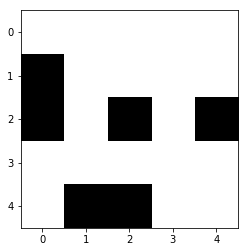

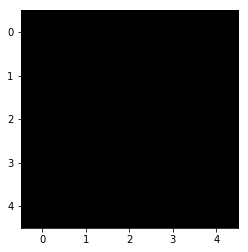

In [7]:
Simulation_op=simulation_op(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,1000,seuil)

#Affichage des opinions de départ
Opinions_start=Simulation_op[0]
fig=plt.figure()
im=plt.imshow(Opinions_start,cmap='binary',vmin=0,vmax=1)

#Affichage des opinions d'arrivée
Opinions_end=Simulation_op[-1]
fig=plt.figure()
im=plt.imshow(Opinions_end,cmap='binary',vmin=0,vmax=1)

#blanc = 0 ; noir = 1

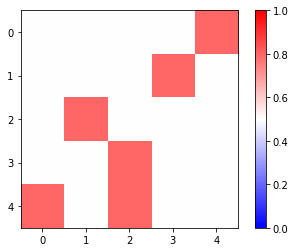

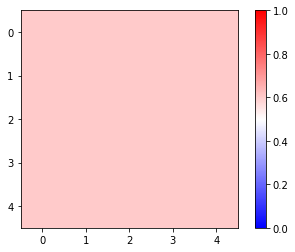

In [8]:
Simulation=simulation_p(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,500,seuil)

#Affichage des convictions de départ
Convictions_start=Simulation[0]
fig=plt.figure()
im=plt.imshow(Convictions_start,cmap='bwr',vmin=0,vmax=1)
plt.colorbar()

#Affichage des convictions de fin de simulation

Convictions_end=Simulation[-1]
fig=plt.figure()
im=plt.imshow(Convictions_end,cmap='bwr',vmin=0,vmax=1)
plt.colorbar()

# CONSULTATION A DISTANCE

Dans cette deuxième partie, nous nous intéresserons à la transmission d'une fake news à distance, c'est-à-dire par le biais d'un organisme médiatique ou d'un réseau social. Des personnes physiquement éloignées pourront alors interagir.  

**Processus détaillé :**  
- **1ère étape : mise à jour des convictions**
    - 


De plus, la conviction sera affectée par la **crédibilité de la news** $news$ par la loi suivante : $ p_i \leftarrow p_i + fp_i \cdot ( news - p_i ) $ 

In [9]:
#Influence crébibilité news sur le p d'une personne
news = np.random.random_sample()
print('Crédibilité de l\'info:',news)

def influ_credib_news(news,p,fp):
    #news: crédibilité de la news
    #p: param déterminant le chgt ou non de l'opinion    
    i = p
    i = i+fp*(news-i)
    return i

print(influ_credib_news(news,0.5,0.75))

Crédibilité de l'info: 0.5237329968723625
0.517799747654272


# II-) Simulation

In [10]:
#Initialisation d'un système avec organismes médiatiques:
List_om=np.random.choice(range(1,(N_1dim**2)+1), size=nb_om, replace=False)
print(List_om)

def init_ac_om(reseau,list_om):
    for name in reseau:
        if name[0] != 'O':
            if int(name) in set(list_om):
                reseau['OM'+str(name)]=(0,0,np.random.uniform(low=0.7,high=1.0),0.5)
                del reseau[name]
    return reseau

Pop_ac_om=init_ac_om(Reseau_discu,List_om)
print('Population avec médias : \n',Pop_ac_om)

[4 5 1]
Population avec médias : 
 {'2': (0, 0, 0.2256361077827962, 0.5), '3': (0, 0, 0.3071406295184057, 0.5), '6': (0, 0, 0.9814067107664208, 0.5), '7': (0, 0, 0.11267384790437995, 0.5), '8': (0, 0, 0.9282330236719704, 0.5), '9': (0, 0, 0.5740796820706868, 0.5), '10': (0, 0, 0.900853592147689, 0.5), '11': (0, 0, 0.7221140808393669, 0.5), '12': (0, 0, 0.9027611597210876, 0.5), '13': (0, 0, 0.1630288261000682, 0.5), '14': (0, 0, 0.7535807629470355, 0.5), '15': (0, 0, 0.5453615802596332, 0.5), '17': (0, 0, 0.06887620523149851, 0.5), '19': (0, 0, 0.806468696978576, 0.5), '20': (0, 0, 0.6238142908964903, 0.5), '21': (0, 0, 0.6198234139864875, 0.5), '22': (0, 0, 0.7729139723896957, 0.5), '23': (0, 0, 0.3673707174661446, 0.5), '25': (0, 0, 0.6199729594453469, 0.5), 'OM16': (0, 0, 0.8673424988949627, 0.5), 'OM18': (0, 0, 0.793634564127807, 0.5), 'OM24': (0, 0, 0.79265513541266, 0.5), 'OM1': (0, 0, 0.7737340813026939, 0.5), 'OM4': (0, 0, 0.7706124572018547, 0.5), 'OM5': (0, 0, 0.8921809732307

In [43]:
#Lancement du fake news
#mal: degré de malveillance(pourcentage des organisations médiatiques qui publient de la fake news, compris entre 0 et 1)

def lancement_fake_news(reseau, list_om, mal):
    m=len(list_om)/100  #m: 1% degré de malveillance
    print(m)
    n=0
    for name in reseau:
        if n<mal:
            if name[0] != 'O':
                
                if int(name) in set(list_om):
                    print("kre")
                    reseau['OM'+str(name)]=(1,1,np.random.uniform(low=0.7,high=1.0),0.5)
                    del reseau[name]
                n=n+m
                print('n=',n)
                    
    return reseau

        
Pop_ap_lancement=lancement_fake_news(Reseau_discu,List_om,0.8)
print('Liste des organisations médiatiques: \n',List_om)
print('Population après lancement du fake news : \n',Pop_ap_lancement)

0.03
n= 0.03
n= 0.06
n= 0.09
n= 0.12
n= 0.15
n= 0.18
n= 0.21
n= 0.24
n= 0.27
n= 0.30000000000000004
n= 0.33000000000000007
n= 0.3600000000000001
n= 0.3900000000000001
n= 0.42000000000000015
n= 0.4500000000000002
n= 0.4800000000000002
n= 0.5100000000000002
n= 0.5400000000000003
n= 0.5700000000000003
Liste des organisations médiatiques: 
 [4 5 1]
Population après lancement du fake news : 
 {'2': (0, 0, 0.2256361077827962, 0.5), '3': (0, 0, 0.3071406295184057, 0.5), '6': (0, 0, 0.9814067107664208, 0.5), '7': (0, 0, 0.11267384790437995, 0.5), '8': (0, 0, 0.9282330236719704, 0.5), '9': (0, 0, 0.5740796820706868, 0.5), '10': (0, 0, 0.900853592147689, 0.5), '11': (0, 0, 0.7221140808393669, 0.5), '12': (0, 0, 0.9027611597210876, 0.5), '13': (0, 0, 0.1630288261000682, 0.5), '14': (0, 0, 0.7535807629470355, 0.5), '15': (0, 0, 0.5453615802596332, 0.5), '17': (0, 0, 0.06887620523149851, 0.5), '19': (0, 0, 0.806468696978576, 0.5), '20': (0, 0, 0.6238142908964903, 0.5), '21': (0, 0, 0.61982341398648

In [11]:
def simulation_op_distance(reseau,n_1dim,mat_pop,names,steps,seuil):
    """retourne la matrice des OPINIONS de la population après un certain nb d'étapes"""
    
    M=matrice_opinions(reseau,n_1dim)
    results=[]
    results.append(M.copy())
    
    for simu in range(steps):
        i=np.random.choice(names)
        List_discu=selection_voisinage(mat_pop,n_1dim)
        Res_p_changé=influ_voisinage(List_discu,reseau,seuil)
        for c in Res_p_changé:
            op,deja,fp,p=Res_p_changé[c]
            if p>0.5 and op==0:
                op=1
                Res_p_changé[c]=(op,deja,fp,p)
            elif p<0.5 and op==1:
                op=0
                Res_p_changé[c]=(op,deja,fp,p)
        Op=[]
        P=[]
        for e in Res_p_changé:
            op,deja,fp,p=Res_p_changé[e]
            Op.append(op)
            P.append(p)
        Op_final=np.reshape(Op, (n_1dim,n_1dim))
        P_final=np.reshape(P, (n_1dim,n_1dim))
        results.append(Op_final.copy())
        
    return results

simulation_op_distance(init_sys_avec_malv(N_1dim,nb_malv),N_1dim,Population,Noms_reseau_discu,steps,seuil)

[array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0.]]), array([[1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 1, 1, 1],
        [0, 0, 0, 1, 0]]), array([[1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0]]), array([[1, 1, 1, 1, 0],
        [1, 0, 0, 1, 1],
        [1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0]]), array([[1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0]]), array([[1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [1, 0, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0]]), array([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [1, 1, 1, 

In [19]:
type(int("o22"))!=int

ValueError: invalid literal for int() with base 10: 'o22'